In [1]:
# Environment Setup
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -U transformers accelerate bitsandbytes datasets scipy matplotlib pandas tqdm wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from datasets import load_dataset, concatenate_datasets
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import copy
import gc
import wandb
import time

# Verify Hardware
print(f"PyTorch: {torch.__version__}")
try:
    _ = torch.float8_e4m3fn
    print("✅ Hardware Ready: Native FP8 Supported.")
except AttributeError:
    raise RuntimeError("❌ Error: FP8 not supported. Use L4 or A100 GPU.")

device = "cuda"

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
PyTorch: 2.5.1+cu121
✅ Hardware Ready: Native FP8 Supported.


In [2]:
# [Cell 2] Configuration & Metrics
WANDB_PROJECT_NAME = "KLD_Quantization_FP4_vs_FP8"
MODEL_ID = "Qwen/Qwen2.5-1.5B-Instruct"
EVAL_SAMPLES = 200  # Keep small for speed
CALIB_SAMPLES = 128
SENSITIVITY_THRESHOLDS = [0.0, 0.01, 0.05, 0.10] # 0%, 1%, 5%, 10% kept in BF16

# --- METRIC HELPERS ---

def compute_kld(logits_p, logits_q):
    """Computes KL Divergence between two distributions"""
    p_probs = F.softmax(logits_p, dim=-1)
    q_log_probs = F.log_softmax(logits_q, dim=-1)
    return nn.KLDivLoss(reduction='batchmean')(q_log_probs, p_probs).item()

def calculate_flip_rate(base_preds, new_preds):
    if not base_preds or not new_preds: return 0.0
    flips = sum([1 for b, n in zip(base_preds, new_preds) if b != n])
    return flips / len(base_preds)

def measure_efficiency(model, tokenizer):
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    start = time.time()

    # Generate dummy text
    inputs = tokenizer("Hello world", return_tensors="pt").to(device)
    with torch.no_grad():
        model.generate(**inputs, max_new_tokens=20, min_new_tokens=20)

    end = time.time()
    mem = torch.cuda.max_memory_allocated() / 1024**3
    return (end - start), mem

def compute_perplexity(model, tokenizer):
    # Simplified PPL for speed
    try:
        encodings = tokenizer("\n\n".join(load_dataset("wikitext", "wikitext-2-raw-v1", split="test")["text"][:5]), return_tensors="pt")
        input_ids = encodings.input_ids[:, :2048].to(device) # Cap at 2048
        target_ids = input_ids.clone()
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
        return torch.exp(outputs.loss).item()
    except:
        return float('nan')

def get_mmlu_predictions(model, tokenizer, num_samples):
    # Load or Mock Dataset
    try:
        ds = concatenate_datasets([load_dataset("cais/mmlu", "elementary_mathematics", split='test')])
    except:
        return [], [] # Fail gracefully

    correct = 0
    preds, truths = [], []
    choices = ["A", "B", "C", "D"]
    choice_ids = [tokenizer.encode(c)[0] for c in choices]

    for i in tqdm(range(min(len(ds), num_samples)), desc="Eval", leave=False):
        # Format Prompt
        ex = ds[i]
        prompt = f"Question: {ex['question']}\nOptions:\n" + "\n".join([f"{l}. {o}" for l,o in zip(choices, ex['choices'])]) + "\nAnswer:"
        inputs = tokenizer.apply_chat_template([{"role": "user", "content": prompt}], tokenize=True, return_tensors="pt", add_generation_prompt=True).to(device)

        with torch.no_grad():
            outputs = model(inputs)
            logits = outputs.logits[0, -1, choice_ids]
            pred = choices[torch.argmax(logits).item()]

        preds.append(pred)
        truths.append(choices[ex['answer']])

    return preds, truths

def evaluate_full_suite(model, tokenizer, name, base_preds=None):
    print(f"--- Evaluating: {name} ---")
    preds, truths = get_mmlu_predictions(model, tokenizer, EVAL_SAMPLES)
    acc = sum([1 for p, g in zip(preds, truths) if p == g]) / len(truths) if truths else 0
    ppl = compute_perplexity(model, tokenizer)
    lat, mem = measure_efficiency(model, tokenizer)

    flip = calculate_flip_rate(base_preds, preds) if base_preds else 0.0

    print(f"Results: Acc={acc:.1%}, Flip={flip:.1%}, Mem={mem:.2f}GB")
    return acc, ppl, lat, mem, preds, flip

results_table = []

In [3]:
# [Cell 3] Surgery Mechanics

# 1. FP8 Storage Wrapper (The bridge for PyTorch FP8)
class FP8LinearStorage(nn.Module):
    def __init__(self, original_linear):
        super().__init__()
        self.in_features = original_linear.in_features
        self.out_features = original_linear.out_features

        # Store as FP8 to save memory
        self.weight = nn.Parameter(original_linear.weight.data.to(torch.float8_e4m3fn), requires_grad=False)

        if original_linear.bias is not None:
            self.bias = nn.Parameter(original_linear.bias.data, requires_grad=False)
        else:
            self.register_parameter('bias', None)

    def forward(self, x):
        # Cast to BF16 for computation
        return F.linear(x, self.weight.to(x.dtype), self.bias)

# 2. Generic Recursive Helpers
def recursive_getattr(obj, attr):
    for part in attr.split('.'):
        obj = getattr(obj, part)
    return obj

def recursive_setattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    parent = recursive_getattr(obj, pre) if pre else obj
    setattr(parent, post, val)

# 3. Surgery Function (Universal)
def perform_surgery(model_target, sensitive_names, model_source_bf16):
    """
    Restores specific layers from the quantized model (Target)
    using weights from the Baseline BF16 model (Source).
    """
    print(f"Surgery: Restoring {len(sensitive_names)} layers to BF16...")
    count = 0

    for name in sensitive_names:
        try:
            # Get original BF16 weight
            orig_layer = recursive_getattr(model_source_bf16, name)

            # Create standard Linear layer
            new_layer = nn.Linear(orig_layer.in_features, orig_layer.out_features, bias=(orig_layer.bias is not None))
            new_layer.weight.data = orig_layer.weight.data.to(device)
            if orig_layer.bias is not None:
                new_layer.bias.data = orig_layer.bias.data.to(device)

            # Swap it in!
            recursive_setattr(model_target, name, new_layer)
            count += 1
        except Exception as e:
            print(f"Surgery failed for {name}: {e}")

    print(f"Surgery Complete: {count} layers restored.")

In [4]:
# [Cell 4] Baseline & Profiling
wandb.login()

# 1. Load Baseline (BF16)
print(f"Loading Baseline: {MODEL_ID}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model_bf16 = AutoModelForCausalLM.from_pretrained(MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto")

# 2. Evaluate Baseline
base_acc, base_ppl, base_lat, base_mem, base_preds, _ = evaluate_full_suite(
    model_bf16, tokenizer, "Baseline (BF16)"
)

results_table.append({
    "Method": "Baseline (BF16)", "Threshold": 0,
    "Acc": base_acc, "PPL": base_ppl, "Mem": base_mem, "Flip": 0.0
})

# 3. KLD Profiling
# We profile on BF16 to find "intrinsically sensitive" layers
print("Profiling Sensitivity (KLD)...")
calib_data = tokenizer("Calibration text example for sensitivity analysis...", return_tensors="pt").input_ids.to(device)

sensitivity_map = {}
with torch.no_grad():
    base_logits = model_bf16(calib_data).logits

for name, module in tqdm(model_bf16.named_modules(), desc="Profiling"):
    if isinstance(module, nn.Linear) and "lm_head" not in name:
        # Perturb weight (Simulate quantization noise)
        w_orig = module.weight.data.clone()
        # Simple noise simulation: Rounding
        module.weight.data = module.weight.data.to(torch.float16).to(torch.bfloat16)

        # Measure KLD
        with torch.no_grad():
            new_logits = model_bf16(calib_data).logits
            kld = compute_kld(base_logits, new_logits)
            sensitivity_map[name] = kld

        # Restore
        module.weight.data = w_orig

# Sort layers by sensitivity (Highest KLD first)
sorted_layers = sorted(sensitivity_map.items(), key=lambda x: x[1], reverse=True)
all_sensitive_names = [n for n,s in sorted_layers]
print(f"Profiling Done. Identified {len(all_sensitive_names)} linear layers.")

# Offload Baseline to CPU to save GPU RAM for experiments
model_bf16.cpu()
torch.cuda.empty_cache()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yq171014 (yq171014-columbia-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Loading Baseline: Qwen/Qwen2.5-1.5B-Instruct...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

--- Evaluating: Baseline (BF16) ---


README.md: 0.00B [00:00, ?B/s]

dataset_infos.json: 0.00B [00:00, ?B/s]

elementary_mathematics/test-00000-of-000(…):   0%|          | 0.00/41.1k [00:00<?, ?B/s]

elementary_mathematics/validation-00000-(…):   0%|          | 0.00/9.38k [00:00<?, ?B/s]

elementary_mathematics/dev-00000-of-0000(…):   0%|          | 0.00/4.55k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/378 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/41 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/5 [00:00<?, ? examples/s]

Eval:   0%|          | 0/200 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Results: Acc=37.5%, Flip=0.0%, Mem=2.89GB
Profiling Sensitivity (KLD)...


Profiling: 0it [00:00, ?it/s]

Profiling Done. Identified 196 linear layers.


In [5]:
# [Cell 5] Experiment A: KLD-Guided FP4 (NF4) - Fixed Types
print("\n=== Experiment A: FP4 (NF4) ===")

for threshold in SENSITIVITY_THRESHOLDS:
    print(f"\nTesting Threshold: {threshold:.0%}")

    # 1. Load NF4 Model (Aligned to BFloat16)
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16  # Compute in BF16
    )

    model_nf4 = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        quantization_config=bnb_config,
        torch_dtype=torch.bfloat16,            # <--- FIX: Load base model in BF16 too
        device_map="auto"
    )

    # 2. Determine Layers to Restore
    num_restore = int(len(all_sensitive_names) * threshold)
    layers_to_restore = all_sensitive_names[:num_restore]

    # 3. Surgery
    if layers_to_restore:
        # Note: model_bf16 is already on CPU from Cell 4, so surgery handles the move
        perform_surgery(model_nf4, layers_to_restore, model_bf16)

    # 4. Evaluate
    # Pass base_preds if available, otherwise flip rate will be 0.0 for first run
    run = wandb.init(project=WANDB_PROJECT_NAME, name=f"FP4-KLD-{threshold}", reinit=True)
    acc, ppl, lat, mem, preds, flip = evaluate_full_suite(
        model_nf4, tokenizer, f"FP4 (Thresh={threshold})",
        base_preds if 'base_preds' in globals() else None
    )

    # 5. Log
    wandb.log({"Accuracy": acc, "Flip_Rate": flip, "Memory": mem, "Perplexity": ppl, "Method": "FP4"})
    results_table.append({"Method": "FP4", "Threshold": threshold, "Acc": acc, "PPL": ppl, "Mem": mem, "Flip": flip})

    del model_nf4
    torch.cuda.empty_cache()
    run.finish()


=== Experiment A: FP4 (NF4) ===

Testing Threshold: 0%


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


--- Evaluating: FP4 (Thresh=0.0) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=37.5%, Flip=29.5%, Mem=1.20GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Accuracy,0.375
Flip_Rate,0.295
Memory,1.19538
Method,FP4
Perplexity,10.56186



Testing Threshold: 1%
Surgery: Restoring 1 layers to BF16...
Surgery Complete: 1 layers restored.


--- Evaluating: FP4 (Thresh=0.01) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=36.0%, Flip=29.5%, Mem=1.91GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Accuracy,0.36
Flip_Rate,0.295
Memory,1.91118
Method,FP4
Perplexity,10.53201



Testing Threshold: 5%
Surgery: Restoring 9 layers to BF16...
Surgery Complete: 9 layers restored.


--- Evaluating: FP4 (Thresh=0.05) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=36.0%, Flip=30.5%, Mem=2.72GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Accuracy,0.36
Flip_Rate,0.305
Memory,2.72062
Method,FP4
Perplexity,10.55842



Testing Threshold: 10%
Surgery: Restoring 19 layers to BF16...
Surgery Complete: 19 layers restored.


--- Evaluating: FP4 (Thresh=0.1) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=35.0%, Flip=29.5%, Mem=3.51GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Accuracy,0.35
Flip_Rate,0.295
Memory,3.51143
Method,FP4
Perplexity,10.70896


In [6]:
# [Cell 6] Experiment B: KLD-Guided FP8 (Native) - Robust Logic
print("\n=== Experiment B: FP8 (Native) ===")

for threshold in SENSITIVITY_THRESHOLDS:
    print(f"\nTesting Threshold: {threshold:.0%}")

    # 1. Load Fresh BF16 Model (The Baseline)
    # We start with high precision and selectively downgrade layers to FP8
    model_fp8 = AutoModelForCausalLM.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.bfloat16,
        device_map="auto"
    )

    # 2. Determine which layers to KEEP in BF16 (Sensitive ones)
    # These layers will NOT be touched by the FP8 wrapper
    num_keep = int(len(all_sensitive_names) * threshold)
    layers_to_keep_bf16 = set(all_sensitive_names[:num_keep]) # Use set for fast lookup

    # 3. Identify Layers to Quantize
    print(f"Applying FP8 Quantization (Keeping top {num_keep} layers in BF16)...")

    layers_to_replace = []
    for name, module in model_fp8.named_modules():
        if isinstance(module, nn.Linear):
            # Rule 1: Never quantize the output head (breaks embeddings due to tied weights)
            if "lm_head" in name:
                continue

            # Rule 2: If it's in our "Sensitive List", skip it (Keep BF16)
            if name in layers_to_keep_bf16:
                continue

            # Otherwise, mark for FP8 conversion
            layers_to_replace.append((name, module))

    # 4. Execute Replacement (Standard BF16 Linear -> FP8 Wrapper)
    for name, module in tqdm(layers_to_replace, desc="Quantizing"):
        # Navigate to parent module
        parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
        child_name = name.split('.')[-1]
        parent = model_fp8.get_submodule(parent_name) if parent_name else model_fp8

        # Swap: Create FP8 Wrapper from current BF16 layer
        # This converts weights to FP8 storage immediately to save memory
        setattr(parent, child_name, FP8LinearStorage(module))

        # Force cleanup of the old BF16 layer to reclaim VRAM
        del module

    # Clear VRAM fragmentation before evaluation
    torch.cuda.empty_cache()
    gc.collect()

    # 5. Evaluate
    # Pass base_preds if they exist to calculate Flip Rate
    run = wandb.init(project=WANDB_PROJECT_NAME, name=f"FP8-KLD-{threshold}", reinit=True)

    acc, ppl, lat, mem, preds, flip = evaluate_full_suite(
        model_fp8,
        tokenizer,
        f"FP8 (Thresh={threshold})",
        base_preds if 'base_preds' in globals() else None
    )

    # 6. Log Results
    wandb.log({
        "Accuracy": acc,
        "Flip_Rate": flip,
        "Memory": mem,
        "Perplexity": ppl,
        "Method": "FP8",
        "Threshold": threshold
    })

    results_table.append({
        "Method": "FP8",
        "Threshold": threshold,
        "Acc": acc,
        "PPL": ppl,
        "Mem": mem,
        "Flip": flip
    })

    # Cleanup for next iteration
    del model_fp8
    torch.cuda.empty_cache()
    run.finish()


=== Experiment B: FP8 (Native) ===

Testing Threshold: 0%
Applying FP8 Quantization (Keeping top 0 layers in BF16)...


Quantizing:   0%|          | 0/196 [00:00<?, ?it/s]

--- Evaluating: FP8 (Thresh=0.0) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=38.0%, Flip=11.0%, Mem=4.22GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Threshold,▁
Accuracy,0.38
Flip_Rate,0.11
Memory,4.22085
Method,FP8
Perplexity,10.596
Threshold,0



Testing Threshold: 1%
Applying FP8 Quantization (Keeping top 1 layers in BF16)...


Quantizing:   0%|          | 0/195 [00:00<?, ?it/s]

--- Evaluating: FP8 (Thresh=0.01) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=37.0%, Flip=11.0%, Mem=4.15GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Threshold,▁
Accuracy,0.37
Flip_Rate,0.11
Memory,4.15322
Method,FP8
Perplexity,10.6152
Threshold,0.01



Testing Threshold: 5%
Applying FP8 Quantization (Keeping top 9 layers in BF16)...


Quantizing:   0%|          | 0/187 [00:00<?, ?it/s]

--- Evaluating: FP8 (Thresh=0.05) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=37.0%, Flip=10.0%, Mem=4.10GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Threshold,▁
Accuracy,0.37
Flip_Rate,0.1
Memory,4.09506
Method,FP8
Perplexity,10.64627
Threshold,0.05



Testing Threshold: 10%
Applying FP8 Quantization (Keeping top 19 layers in BF16)...


Quantizing:   0%|          | 0/177 [00:00<?, ?it/s]

--- Evaluating: FP8 (Thresh=0.1) ---


Eval:   0%|          | 0/200 [00:00<?, ?it/s]

Results: Acc=37.5%, Flip=8.5%, Mem=4.05GB


Accuracy,▁
Flip_Rate,▁
Memory,▁
Perplexity,▁
Threshold,▁
Accuracy,0.375
Flip_Rate,0.085
Memory,4.04952
Method,FP8
Perplexity,10.67663
Threshold,0.1


            Method  Threshold    Acc        PPL       Mem   Flip
0  Baseline (BF16)       0.00  0.375  10.415267  2.891026  0.000
1              FP4       0.00  0.375  10.561856  1.195379  0.295
2              FP4       0.01  0.360  10.532011  1.911178  0.295
3              FP4       0.05  0.360  10.558422  2.720619  0.305
4              FP4       0.10  0.350  10.708956  3.511432  0.295
5              FP8       0.00  0.380  10.595997  4.220849  0.110
6              FP8       0.01  0.370  10.615196  4.153222  0.110
7              FP8       0.05  0.370  10.646268  4.095056  0.100
8              FP8       0.10  0.375  10.676625  4.049518  0.085


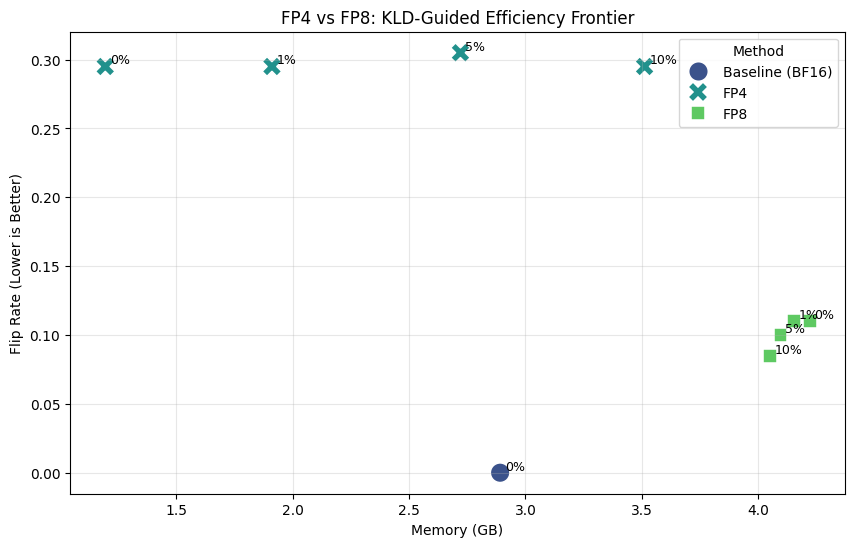

In [7]:
# [Cell 7] Final Visualization
df = pd.DataFrame(results_table)
print(df)

# Plot Efficiency Frontier (Memory vs Flip Rate)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Mem', y='Flip', hue='Method', style='Method', s=200, palette='viridis')

# Add labels
for i in range(df.shape[0]):
    row = df.iloc[i]
    plt.text(row.Mem+0.02, row.Flip+0.002, f"{row.Threshold:.0%}", fontsize=9)

plt.title("FP4 vs FP8: KLD-Guided Efficiency Frontier")
plt.xlabel("Memory (GB)")
plt.ylabel("Flip Rate (Lower is Better)")
plt.grid(True, alpha=0.3)
plt.show()